Best hyperparameters found by GA: num_filters1=30, num_filters2=49, dense_units=380, learning_rate=0.005413828745785601
Epoch 1/50
704/704 [==============================] - 82s 115ms/step - loss: 1.5275 - accuracy: 0.4697 - val_loss: 1.1218 - val_accuracy: 0.6020
Epoch 2/50
704/704 [==============================] - 79s 113ms/step - loss: 1.0562 - accuracy: 0.6278 - val_loss: 1.3836 - val_accuracy: 0.5606
Epoch 3/50
704/704 [==============================] - 85s 121ms/step - loss: 0.8994 - accuracy: 0.6841 - val_loss: 1.1458 - val_accuracy: 0.6448
Epoch 4/50
704/704 [==============================] - 85s 120ms/step - loss: 0.8039 - accuracy: 0.7173 - val_loss: 0.7294 - val_accuracy: 0.7474
Epoch 5/50
704/704 [==============================] - 81s 115ms/step - loss: 0.7436 - accuracy: 0.7392 - val_loss: 0.8561 - val_accuracy: 0.7090
Epoch 6/50
704/704 [==============================] - 80s 114ms/step - loss: 0.7084 - accuracy: 0.7520 - val_loss: 0.8234 - val_accuracy: 0.7182
Epoch 7/50

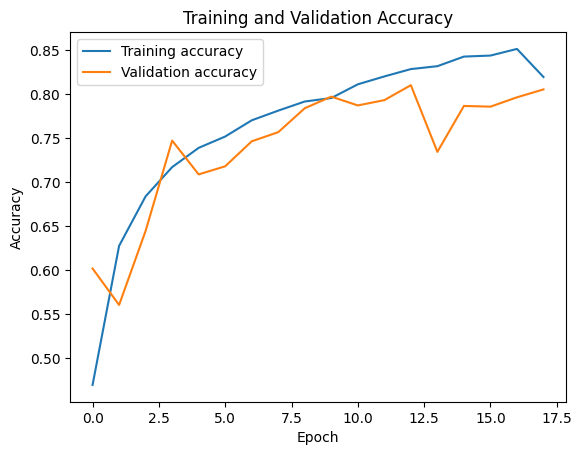

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from deap import base, creator, tools
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

# Split the training data into train and validation sets
validation_split = 0.1
split_index = int(len(x_train) * validation_split)
x_val, y_val = x_train[:split_index], y_train[:split_index]
x_train, y_train = x_train[split_index:], y_train[split_index:]

sample_size = 5000  # Adjust this value as needed
sample_indices = np.random.choice(np.arange(x_train.shape[0]), sample_size, replace=False)

x_train_small = x_train[sample_indices]
y_train_small = y_train[sample_indices]

# Create fitness and individual classes for DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize the individual and population functions for DEAP
def init_individual():
    num_filters1 = random.randint(16, 128)
    num_filters2 = random.randint(16, 128)
    dense_units = random.randint(128, 1024)
    learning_rate = random.uniform(1e-5, 1e-2)
    return creator.Individual([num_filters1, num_filters2, dense_units, learning_rate])

def init_population(n):
    return [init_individual() for _ in range(n)]

def fitness_function_data(individual):
    num_filters1, num_filters2, dense_units, learning_rate = individual
    num_filters1 = int(num_filters1)
    num_filters2 = int(num_filters2)
    dense_units = int(dense_units)
    
    print(f"Training with hyperparameters: num_filters1={num_filters1}, num_filters2={num_filters2}, "
          f"dense_units={dense_units}, learning_rate={learning_rate}")

    model = Sequential([
        Conv2D(num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(num_filters1, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train_small, y_train_small, epochs=5, batch_size=256,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)
    
    val_loss = min(history.history['val_loss'])
    return val_loss,

# Define the evaluation, crossover, and mutation functions for DEAP
toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", init_population, n=10)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selBest)
toolbox.register("evaluate", fitness_function_data)

# # Run the GA optimizer
# population = toolbox.population()
# NGEN = 20

# for gen in range(NGEN):
#     print(f"Generation {gen + 1} of {NGEN}")
#     offspring = tools.selBest(population, len(population) // 2)
#     offspring = list(offspring)
#     for child1, child2 in zip(offspring[::2], offspring[1::2]):
#         if random.random() < 0.5:
#             toolbox.mate(child1, child2)
#             del child1.fitness.values
#             del child2.fitness.values

#     for mutant in offspring:
#         if random.random() < 0.2:
#             toolbox.mutate(mutant)
#             del mutant.fitness.values

#     invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#     fitnesses = map(toolbox.evaluate, invalid_ind)
#     for ind, fit in zip(invalid_ind, fitnesses):
#         ind.fitness.values = fit

#     # Sort the population based on their fitness values
#     population = sorted(population, key=lambda ind: ind.fitness.values[0] if ind.fitness.valid else float('inf'))

#     # Replace the least fit individuals with offspring
#     population[:len(offspring)] = offspring
    
#     # Print the best fitness value in the current generation
#     best_fitness = min(ind.fitness.values[0] for ind in population if ind.fitness.valid)
#     print(f"Best fitness in generation {gen + 1}: {best_fitness:.4f}")

# best_individual = tools.selBest(population, 1)[0]

# # Extract the best hyperparameters
# best_num_filters1, best_num_filters2, best_dense_units, best_learning_rate = best_individual
# best_num_filters1 = int(best_num_filters1)
# best_num_filters2 = int(best_num_filters2)
# best_dense_units = int(best_dense_units)


best_num_filters1 = 30
best_num_filters2 = 49
best_dense_units = 380
best_learning_rate = 0.005413828745785601

print(f"Best hyperparameters found by GA: num_filters1={best_num_filters1}, "
      f"num_filters2={best_num_filters2}, dense_units={best_dense_units}, "
      f"learning_rate={best_learning_rate}")

# Train the model with the best hyperparameters
model = Sequential([
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(best_dense_units, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=best_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, restore_best_weights=True)

start_time = time.time()
history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

end_time = time.time()

training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f'Test accuracy: {test_acc}')

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

# Calculate ROC-AUC for multi-class classification
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc}')

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



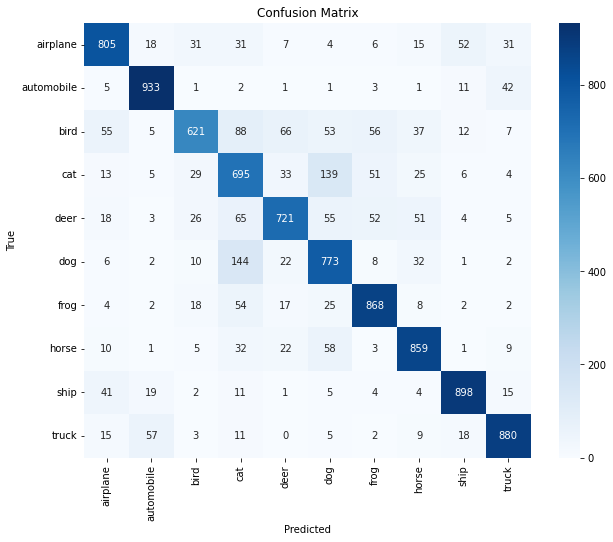

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
confusion_matrix = np.array([
    [805, 18, 31, 31, 7, 4, 6, 15, 52, 31],
    [5, 933, 1, 2, 1, 1, 3, 1, 11, 42],
    [55, 5, 621, 88, 66, 53, 56, 37, 12, 7],
    [13, 5, 29, 695, 33, 139, 51, 25, 6, 4],
    [18, 3, 26, 65, 721, 55, 52, 51, 4, 5],
    [6, 2, 10, 144, 22, 773, 8, 32, 1, 2],
    [4, 2, 18, 54, 17, 25, 868, 8, 2, 2],
    [10, 1, 5, 32, 22, 58, 3, 859, 1, 9],
    [41, 19, 2, 11, 1, 5, 4, 4, 898, 15],
    [15, 57, 3, 11, 0, 5, 2, 9, 18, 880]
])

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()